In [22]:
import pandas as pd
import numpy as np
import sys
import os
sys.path.append(os.path.abspath(os.path.join(os.getcwd(), '../../')))



df = pd.read_csv(os.path.join(os.getcwd(), "../../data/total_2_4am.csv"), index_col=0)

df

,day_starting_at_4am,open,high,low,close,volume_krw,volume_market
0,2019-12-31 04:00:00,8342000.0,8390000.0,8260000.0,8278000.0,2.866828e+09,344.849603
1,2020-01-01 04:00:00,8278000.0,8387000.0,8269000.0,8342000.0,8.275045e+09,993.684539
2,2020-01-02 04:00:00,8340000.0,8341000.0,8030000.0,8085000.0,1.495244e+10,1822.111090
3,2020-01-03 04:00:00,8085000.0,8525000.0,7910000.0,8485000.0,4.902840e+10,5904.063410
4,2020-01-04 04:00:00,8486000.0,8520000.0,8382000.0,8429000.0,1.778679e+10,2105.758057
...,...,...,...,...,...,...,...
1696,2024-08-22 04:00:00,82390000.0,83600000.0,81280000.0,81962000.0,2.422034e+11,2932.662045
1697,2024-08-23 04:00:00,81955000.0,84984000.0,81871000.0,84690000.0,2.671331e+11,3213.124045
1698,2024-08-24 04:00:00,84672000.0,86500000.0,84540000.0,85742000.0,2.942932e+11,3432.962091
1699,2024-08-25 04:00:00,85742000.0,86199000.0,85300000.0,85990000.0,1.217810e+11,1421.137462


In [23]:
import pandas as pd
import numpy as np
from performance import get_performance

# Assuming the dataframe is named df
# Calculate the price change
df['price_change'] = df['close'].diff()

df[f"50_momentum"] = 0

# Calculate the gains and losses
df['gain'] = np.where(df['price_change'] > 0, df['price_change'], 0)
df['loss'] = np.where(df['price_change'] < 0, -df['price_change'], 0)

# Calculate the average gain and average loss
window_length = 14
df['avg_gain'] = df['gain'].rolling(window=window_length, min_periods=1).mean()
df['avg_loss'] = df['loss'].rolling(window=window_length, min_periods=1).mean()

# Calculate the RS (Relative Strength) and RSI
df['rs'] = df['avg_gain'] / df['avg_loss']
df['rsi'] = 100 - (100 / (1 + df['rs']))

# Implement RSI strategy for long positions only
df['signal'] = 0  # Default to no position
for i in range(51, len(df)):
    df.loc[i, "50_momentum"] = df.loc[i, "close"] - df.loc[i-50, "close"]
    # 매수 조건
    # if (df.loc[i, 'rsi'] >= 30) and df.loc[i-1, 'rsi'] < 30 and df.loc[i, "50_momentum"] >= 0:
    if (df.loc[i, 'rsi'] >= 30) and df.loc[i-1, 'rsi'] < 30:
    # if (df.loc[i, 'rsi'] >= 30) and (df.loc[i-1, 'rsi'] < 30:
        df.loc[i, 'signal'] = 1
    # 매도 조건
    elif (df.loc[i, 'rsi'] <= 70) and (df.loc[i-1, 'rsi'] > 70):
        df.loc[i, 'signal'] = -1

# # Manage positions with stop loss, take profit, and sell signal
# df['position'] = 0
# df['entry_price'] = np.nan
# df['exit_price'] = np.nan
# holding_position = False

# for i in range(1, len(df)):
#     if df['signal'].iloc[i] == 1 and not holding_position:
#         # Enter position
#         df.loc[i, 'position'] = 1
#         df.loc[i, 'entry_price'] = df.loc[i, 'close']
#         holding_position = True
#     elif holding_position:
#         # Calculate percentage change since entry
#         entry_price = df['entry_price'].iloc[i-1]
#         current_price = df['close'].iloc[i]
#         percent_change = (current_price - entry_price) / entry_price * 100

#         if df['signal'].iloc[i] == -1:  # Sell signal condition
#             # print(f"cond1 on{i}")
#             df.loc[i, 'position'] = 0
#             df.loc[i, 'exit_price'] = current_price
#             holding_position = False
#         elif percent_change <= -5:  # Stop loss condition
#             # print(f"cond2 on{i}")
#             df.loc[i, 'position'] = 0
#             df.loc[i, 'exit_price'] = current_price
#             holding_position = False
#         # elif percent_change >= 30:  # Take profit condition
#         #     print(f"cond3 on{i}")
#         #     df['position'].iloc[i] = 0
#         #     df['exit_price'].iloc[i] = current_price
#         #     holding_position = False
#         else:
#             # Continue holding the position if no sell conditions are met
#             # df['position'].iloc[i] = df['position'].iloc[i-1]
#             df.loc[i, 'position'] = df.loc[i-1, 'position']
#             # df['entry_price'].iloc[i] = df['entry_price'].iloc[i-1]
#             df.loc[i, 'entry_price'] = df.loc[i-1, 'entry_price']
#     else:
#         # No signal and no position
#         # df['position'].iloc[i] = df['position'].iloc[i-1]
#         df.loc[i, 'position'] = df.loc[i-1, 'position']

# Manage positions with stop loss, take profit, and sell signal
df['position'] = 0
df['highest_price'] = np.nan
df['exit_price'] = np.nan
holding_position = False

for i in range(1, len(df)):
    if df.loc[i, 'signal'] == 1 and not holding_position:
        # Enter position
        df.loc[i, 'position'] = 1
        df.loc[i, 'highest_price'] = df.loc[i, 'close']
        holding_position = True
    elif holding_position:
        # Calculate percentage change since entry
        # df['highest_price'].iloc[i] = max(df['highest_price'].iloc[i-1], df['close'].iloc[i])
        df.loc[i, 'highest_price'] = max(df.loc[i-1, 'highest_price'], df.loc[i-1, 'close'])
        highest_price = df.loc[i, 'highest_price']
        current_price = df.loc[i, 'close']
        percent_change = (current_price - highest_price) / highest_price * 100

        if df.loc[i, 'signal'] == -1:  # Sell signal condition
            # print(f"cond1 on{i}")
            df.loc[i, 'position'] = 0
            df.loc[i, 'exit_price'] = current_price
            holding_position = False
        elif percent_change <= -5:  # Stop loss condition
            # print(f"cond2 on{i}")
            df.loc[i, 'position'] = 0
            df.loc[i, 'exit_price'] = current_price
            holding_position = False
        # elif df.loc[i, "50_momentum"] < 0:
        #     df.loc[i, 'position'] = 0
        #     df.loc[i, 'exit_price'] = current_price
        #     holding_position = False
        else:
            # Continue holding the position if no sell conditions are met
            df.loc[i, 'position'] = df.loc[i-1, 'position']

    else:
        # No signal and no position
        # df['position'].iloc[i] = df['position'].iloc[i-1]
        df.loc[i, 'position'] = df.loc[i-1, 'position']
        
# Calculate the strategy returns (only when in a long position)
df['strategy_returns'] = df['position'].shift(1) * df['close'].pct_change()
df['strategy_returns2'] = df['strategy_returns']
        
for i in range(1, len(df)):
    buy_price = df.loc[i-1, "close"]
    buy_price_copy = buy_price
    sell_price = df.loc[i, "close"]
    sell_price_copy = sell_price
    if df.loc[i-1, 'position'] == 1 and df.loc[i-1, 'signal'] == 1:
        # df.loc[i, 'strategy_returns2'] = (df.loc[i,'position'])/(df.loc[i-1, 'position'] * 1.002) -1
        buy_price = df.loc[i-1, "close"] * 1.002
    if df.loc[i, 'position'] == 0 and df.loc[i-1, 'position'] != 0:
        # df.loc[i, 'strategy_returns2'] = (df.loc[i,'position'] * 0.998)/(df.loc[i-1, 'position']) -1
        sell_price = df.loc[i, "close"] * 0.998
    
    if buy_price == buy_price_copy and sell_price == sell_price_copy:
        continue


    df.loc[i, "strategy_returns2"] = sell_price/buy_price - 1

# Calculate the cumulative returns
df['cumulative_returns'] = (1 + df['strategy_returns']).cumprod()
df["cumulative_returns2"] = (1 + df['strategy_returns2']).cumprod()

# Calculate the benchmark cumulative returns (buy and hold strategy)
df['benchmark_returns'] = (1 + df['close'].pct_change()).cumprod()

# Display the results
# print(df[['day_starting_at_4am', 'close', 'rsi', 'signal', 'position', 'cumulative_returns', 'benchmark_returns', 'entry_price', 'exit_price']].tail(10))

# df.to_csv("../../results/rsi/rsi_with_stoploss_takeprofit_sell_signal.csv")

get_performance(df=df, title="rsi_cut_highest5%")


======Investment Summary======
Strategy        : rsi_cut_highest5%
total_return    : 346.53
cagr            : 39.49
mdd             : 28.6
total_return_w_fee : 272.98
cagr_w_fee      : 34.02
mdd_w_fee       : 31.57
investing_days  : 1641


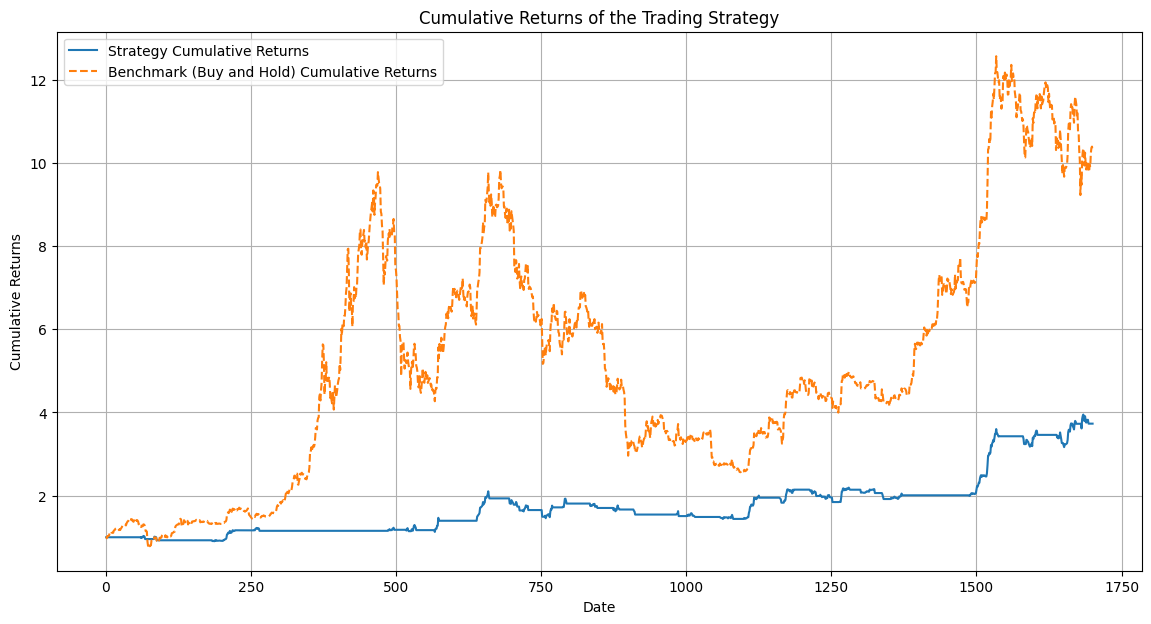

In [24]:
import matplotlib.pyplot as plt
# Plot the cumulative returns
plt.figure(figsize=(14, 7))
plt.plot(df['cumulative_returns2'], label='Strategy Cumulative Returns')
plt.plot(df['benchmark_returns'], label='Benchmark (Buy and Hold) Cumulative Returns', linestyle='--')
plt.title('Cumulative Returns of the Trading Strategy')
plt.xlabel('Date')
plt.ylabel('Cumulative Returns')
plt.legend()
plt.grid(True)
plt.show()
